### Protein Analyzer Notebook
 

### Introduction
This is a notebook which explores the possibility of creating new protein structures using a graph variational autoencoder (GVAE) model. The model is trained on a dataset of protein structures and then used to generate new protein structures. The notebook is divided into the following sections:

### Import Necessary Libraries

(210, 9)
        X        Y       Z AA   Avg_Mass   Avg_Neighbor_Dist  \
0  23.388  -19.139  -9.239  M  149.20784  3.8486709594726562   
1  24.634  -16.649  -6.582  K  146.18934   3.834369659423828   
2  23.024  -14.147  -4.186  A   89.09404  3.7685012817382812   
3  19.519  -14.167  -2.949  F  165.19184  3.7678961753845215   
4  20.762  -13.862   0.649  T  119.12034  3.8312950134277344   

    Max_Neighbor_Dist Neighbor_Count  AA_encoded  
0  3.8486709594726562            1.0           9  
1  3.8486709594726562            2.0           7  
2   3.820068120956421            2.0           0  
3  3.8188579082489014            2.0           3  
4  3.8437318801879883            2.0          15  
Number of nodes: 210
Number of edges: 534
Node features shape: torch.Size([210, 8])


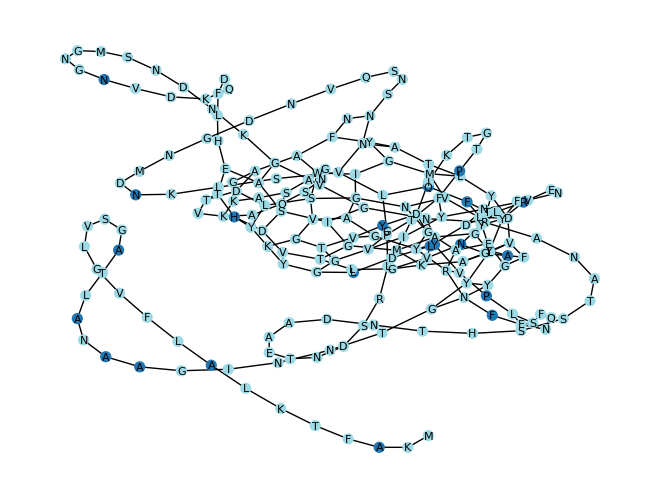

In [1]:
# Import necessary libraries
import os
import pandas as pd

from ProteinAnalyzer import ProteinAnalyzer
from GraphCreatorOneHotEncodedVariant import GraphCreatorOneHotEncodedVariant
from GraphCreator import GraphCreator
from Utils import Utils
import torch
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch_geometric.data import Data
import numpy as np




### Variables for the notebook

In [2]:
# Variables for the notebook

# Set the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Define the file for a demo protein structure
pdb_file = '/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

# Define the directory containing the PDB files
pdb_directory = '/Users/alexchilton/Downloads/archive/just10000'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

In [3]:
#check for gpu
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Load a Demo Protein Structure

(210, 9)
        X        Y       Z AA   Avg_Mass   Avg_Neighbor_Dist  \
0  23.388  -19.139  -9.239  M  149.20784  3.8486709594726562   
1  24.634  -16.649  -6.582  K  146.18934   3.834369659423828   
2  23.024  -14.147  -4.186  A   89.09404  3.7685012817382812   
3  19.519  -14.167  -2.949  F  165.19184  3.7678961753845215   
4  20.762  -13.862   0.649  T  119.12034  3.8312950134277344   

    Max_Neighbor_Dist Neighbor_Count  AA_encoded  
0  3.8486709594726562            1.0           9  
1  3.8486709594726562            2.0           7  
2   3.820068120956421            2.0           0  
3  3.8188579082489014            2.0           3  
4  3.8437318801879883            2.0          15  
Number of nodes: 210
Number of edges: 534
Node features shape: torch.Size([210, 8])


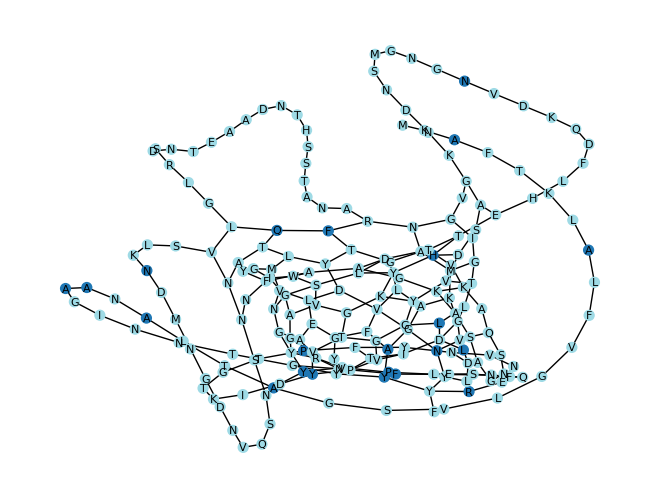

In [4]:
# Create the ProteinAnalyzer and GraphCreator objects
analyzer = ProteinAnalyzer(pdb_file, aa_info_file)
graph_creator = GraphCreator(pdb_file, aa_info_file)

# Generate the autoencoder input DataFrame  
autoencoder_input_df = analyzer.prepare_autoencoder_input()

autoencoder_input_df, le = graph_creator.encode_aa(autoencoder_input_df)
pd.set_option('display.max_columns', None)

print(autoencoder_input_df.shape)
print(autoencoder_input_df.head())

# Unpack the returned tuple
graph = graph_creator.create_graph(autoencoder_input_df)

# Print graph metrics
graph_creator.print_graph_metrics(graph)

# Draw the graph
graph_creator.draw_graph(graph, le)

### Load PDB Files 
and convert all to dfs which have our desired columns

In [5]:

def load_pdb_files(directory):
    ''' Load all PDB files from the specified directory '''
    pdb_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pdb')]
    return pdb_files

def create_autoencoder_input_dfs(pdb_files, aa_info_file):
    ''' Create autoencoder input DataFrames for all PDB files '''
    autoencoder_input_dfs = []
    for pdb_file in pdb_files:
        analyzer = ProteinAnalyzer(pdb_file, aa_info_file)
        autoencoder_input_df = analyzer.prepare_autoencoder_input()
        autoencoder_input_dfs.append(autoencoder_input_df)
    return autoencoder_input_dfs


# Load PDB files
pdb_files = load_pdb_files(pdb_directory)

# Create autoencoder input DataFrames
autoencoder_input_dfs = create_autoencoder_input_dfs(pdb_files, aa_info_file)


### Convert Object Types to Float
and print the types and a head example

In [6]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined convert the onject types to float
autoencoder_input_dfs = Utils.convert_columns_to_float(autoencoder_input_dfs)

# Verify the conversion
print(autoencoder_input_dfs[0].dtypes)
print(autoencoder_input_dfs[0].head())

X                    float64
Y                    float64
Z                    float64
AA                    object
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
dtype: object
        X       Y      Z AA   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -20.246  16.002 -8.805  M  149.20784           3.808177           3.808177   
1 -18.503  12.625 -9.050  A   89.09404           3.824629           3.841081   
2 -20.207   9.839 -7.028  S  105.09344           3.855387           3.869693   
3 -18.856   9.181 -3.462  P  115.13194           3.856041           3.869693   
4 -17.236   5.959 -4.788  L  131.17464           4.212434           4.940235   

   Neighbor_Count  
0             1.0  
1             2.0  
2             2.0  
3             2.0  
4             3.0  


### One Hot Encode the Data

In [7]:

from Utils import Utils
# Assuming autoencoder_input_dfs is already defined
onehot_encoder = Utils.create_onehot_encoder(autoencoder_input_dfs)

encoded_autoencoder_input_dfs = [Utils.encode_values(df, onehot_encoder) for df in autoencoder_input_dfs]
#decoded_autoencoder_input_dfs = [decode_values(df) for df in new_autoencoder_input_dfs]

# Print the first few rows of the first encoded and decoded DataFrame
print(encoded_autoencoder_input_dfs[0].head())
#print(decoded_autoencoder_input_dfs[0].head())

        X       Y      Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -20.246  16.002 -8.805  149.20784           3.808177           3.808177   
1 -18.503  12.625 -9.050   89.09404           3.824629           3.841081   
2 -20.207   9.839 -7.028  105.09344           3.855387           3.869693   
3 -18.856   9.181 -3.462  115.13194           3.856041           3.869693   
4 -17.236   5.959 -4.788  131.17464           4.212434           4.940235   

   Neighbor_Count  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  AA_H  AA_I  AA_K  AA_L  \
0             1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             2.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2             2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3             2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4             3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

   AA_M  AA_N  AA_P  AA_Q  AA_R  AA_S  AA_T  AA_V 

### Create Graphs from Encoded DataFrames

In [8]:
from GraphCreatorOneHotEncodedVariant import GraphCreatorOneHotEncodedVariant
graph_creator = GraphCreatorOneHotEncodedVariant()
graphs = []
for df in encoded_autoencoder_input_dfs:
    graph = graph_creator.create_graph(df)
    graphs.append(graph)

#### ONLY NORMALISE AFTER DOING THE EDGES!!! here would be ok...(should be done??)

### Print the First Few Graphs

Graph 1: 90 nodes, 216 edges


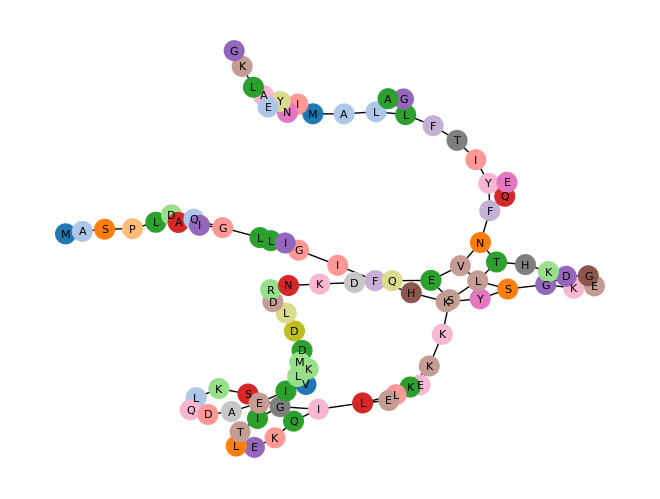

Graph 2: 113 nodes, 250 edges


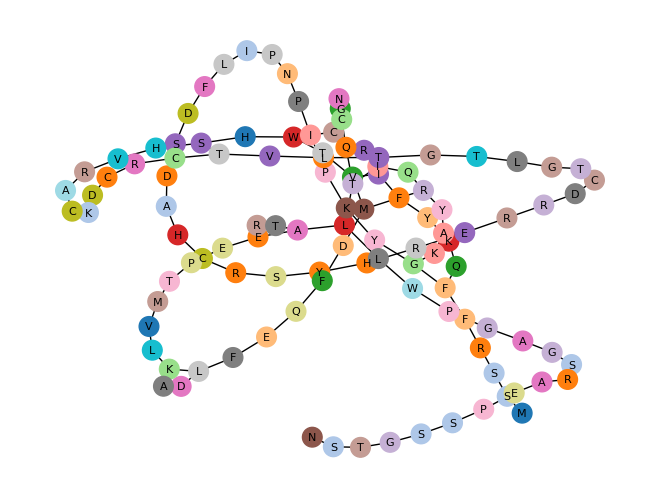

Graph 3: 23 nodes, 44 edges


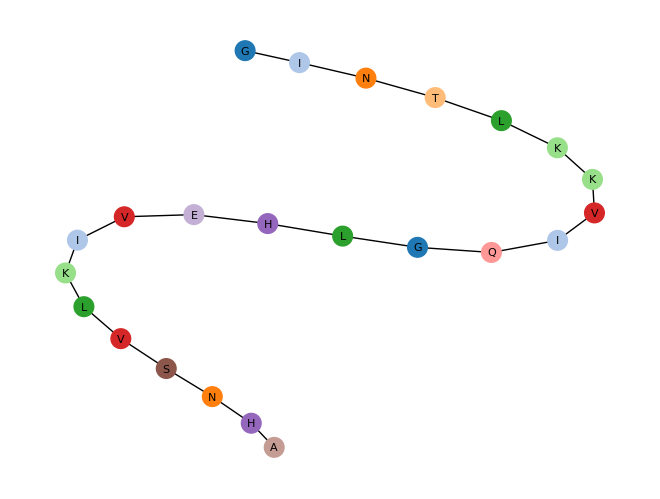

Graph 4: 130 nodes, 318 edges


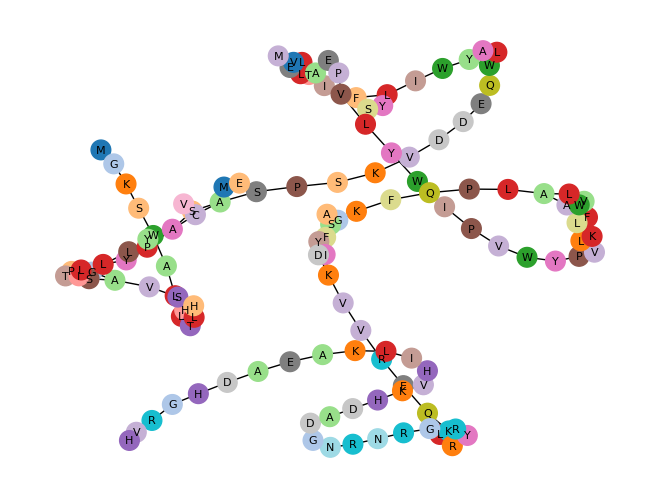

Graph 5: 66 nodes, 148 edges


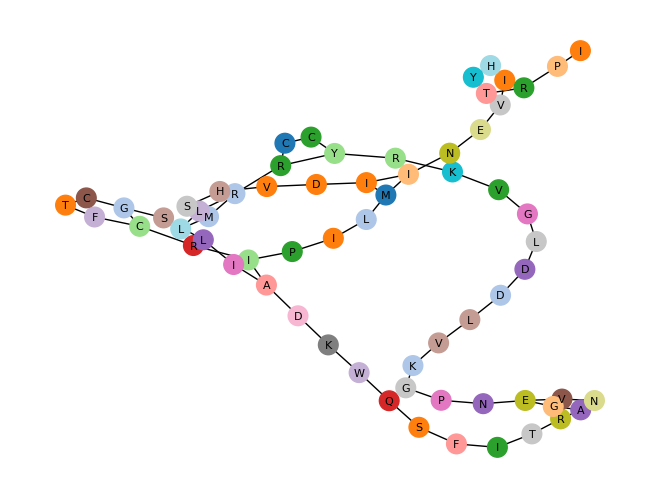

Graph 6: 119 nodes, 276 edges


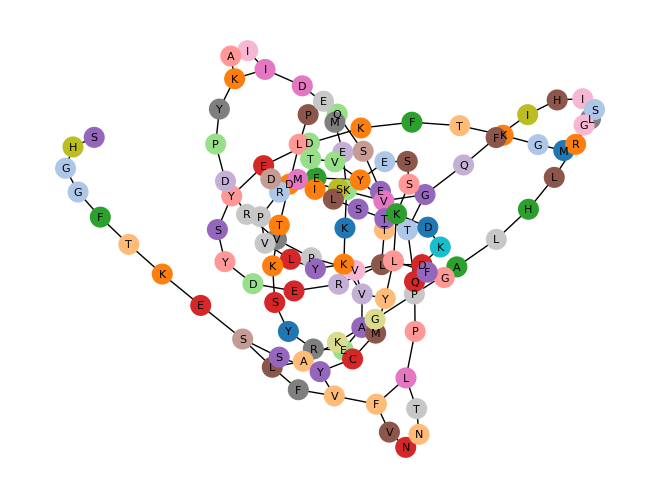

Graph 7: 128 nodes, 284 edges


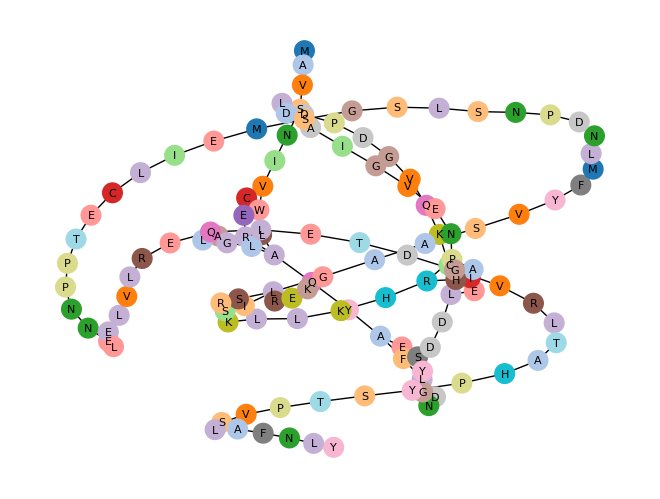

Graph 8: 143 nodes, 354 edges


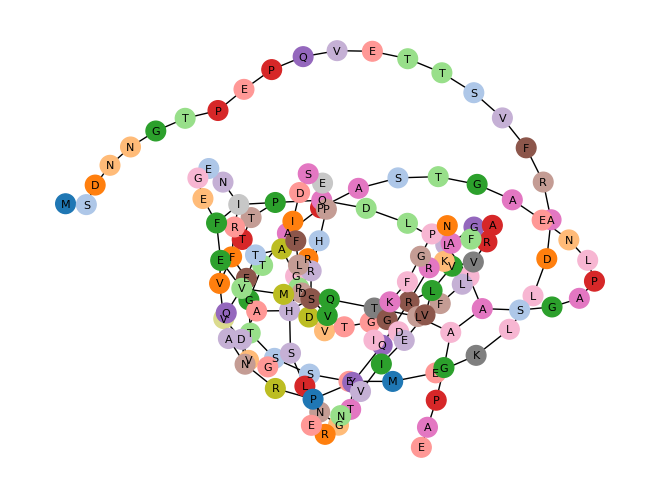

Graph 9: 105 nodes, 252 edges


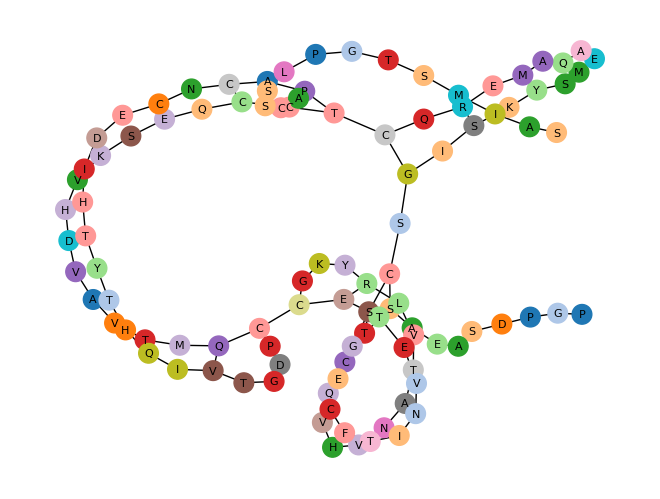

Graph 10: 137 nodes, 322 edges


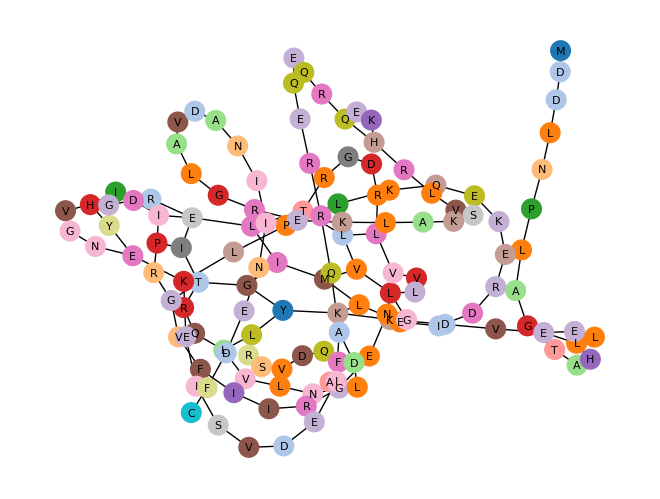

In [9]:
# Now `graphs` contains all the graphs created from the encoded DataFrames
for i, graph in enumerate(graphs[:10]):
    print(f"Graph {i + 1}: {graph.num_nodes} nodes, {graph.num_edges} edges")
    graph_creator.draw_graph(graph, onehot_encoder)

In [10]:
import torch
import torch_geometric.data as tg_data
from torch_geometric.loader import DataLoader
from MolecularGVAE import MolecularGVAE
from MolecularGVAEModule import MolecularGVAEModule, train_gvae

### Lets first look with a latent space of 2...

In [11]:
# First, create your base model (MolecularGVAE)
model_params = {
    'node_features': 27,
    'hidden_dim': 64,
    'latent_dim': 2,
    'max_nodes': 500
}

# Initialize the base GVAE model
base_model = MolecularGVAE(**model_params)

# Wrap it in the Lightning module for training
lightning_model = MolecularGVAEModule(
    model=base_model,
    lr=0.001,
    beta=0.1
)

we have a model lets see what it generates before training

In [12]:
# Example of generating molecules of different sizes
def generate_diverse_molecules(model, size_range=(20, 50), num_molecules=10):
    model.eval()
    molecules = []
    with torch.no_grad():
        for _ in range(num_molecules):
            # Randomly sample a size within the range
            num_nodes = torch.randint(size_range[0], size_range[1], (1,)).item()
            mol = base_model.generate(num_nodes=num_nodes, device='cpu')
            molecules.append(mol)
    return molecules

In [13]:
gen_molecules = generate_diverse_molecules(base_model, size_range=(10, 20), num_molecules=10)

graph_creator.print_first_graph(gen_molecules)


Node 1: tensor([0.3003, 0.3531, 0.4893, 0.5902, 0.3839, 0.7591, 0.6761, 0.4859, 0.1113,
        0.3943, 0.6104, 0.5217, 0.5438, 0.4046, 0.4763, 0.6581, 0.2442, 0.7520,
        0.5281, 0.3557, 0.7403, 0.3405, 0.4679, 0.4505, 0.5420, 0.6080, 0.5143])
Node 2: tensor([0.3090, 0.2424, 0.2956, 0.6070, 0.4407, 0.7034, 0.5939, 0.5381, 0.2354,
        0.5326, 0.6148, 0.4336, 0.5564, 0.5433, 0.5338, 0.6369, 0.5103, 0.6018,
        0.6042, 0.2608, 0.4227, 0.4207, 0.4668, 0.3910, 0.5954, 0.5874, 0.5003])
Node 3: tensor([0.4695, 0.3841, 0.5810, 0.6277, 0.5598, 0.6540, 0.7017, 0.3893, 0.1684,
        0.3401, 0.5205, 0.3978, 0.5487, 0.3012, 0.4641, 0.5755, 0.2684, 0.6227,
        0.5030, 0.4360, 0.7962, 0.3674, 0.5416, 0.4107, 0.5352, 0.5980, 0.5696])
Node 4: tensor([0.2542, 0.1885, 0.3691, 0.6452, 0.3583, 0.6519, 0.5144, 0.5983, 0.2512,
        0.5208, 0.6811, 0.6732, 0.5608, 0.4795, 0.6587, 0.5702, 0.4257, 0.6565,
        0.5254, 0.3251, 0.5392, 0.4197, 0.3406, 0.4403, 0.6302, 0.5949, 0.6130])
Node

In [14]:
# Convert the `AA_` columns in the generated protein graphs to one-hot encoded format
gen_molecules = graph_creator.convert_graphs_to_one_hot(gen_molecules)

In [15]:
# Print each node's features for the first graph
graph_creator.print_first_graph(gen_molecules)

Node 1: tensor([0.3003, 0.3531, 0.4893, 0.5902, 0.3839, 0.7591, 0.6761, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node 2: tensor([0.3090, 0.2424, 0.2956, 0.6070, 0.4407, 0.7034, 0.5939, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node 3: tensor([0.4695, 0.3841, 0.5810, 0.6277, 0.5598, 0.6540, 0.7017, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node 4: tensor([0.2542, 0.1885, 0.3691, 0.6452, 0.3583, 0.6519, 0.5144, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node

Number of nodes: 17
Number of edges: 164
Node features shape: torch.Size([17, 27])


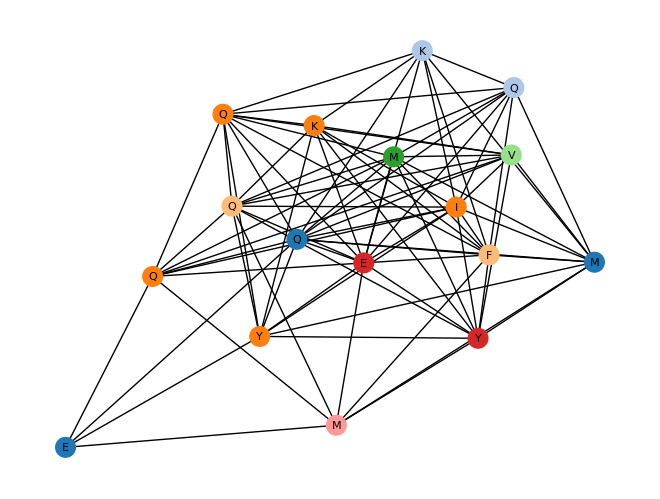

Number of nodes: 19
Number of edges: 206
Node features shape: torch.Size([19, 27])


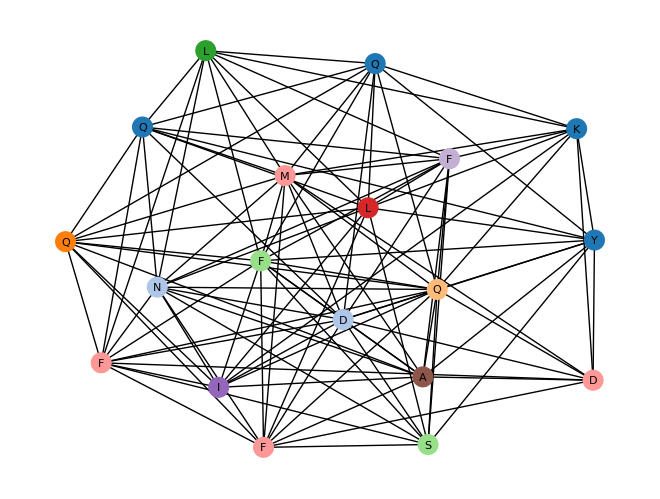

Number of nodes: 17
Number of edges: 148
Node features shape: torch.Size([17, 27])


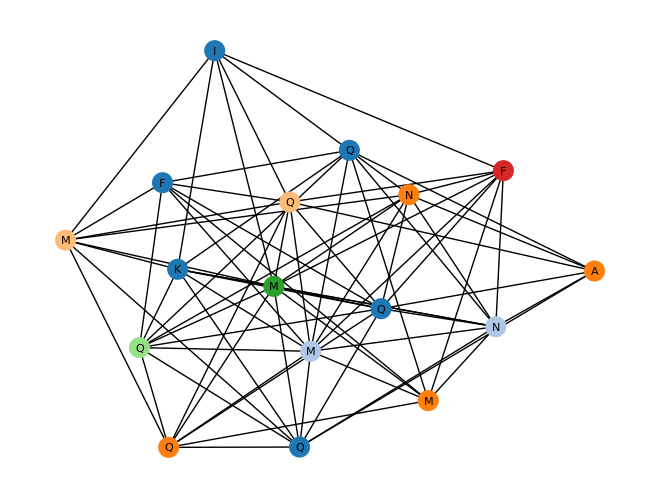

Number of nodes: 19
Number of edges: 190
Node features shape: torch.Size([19, 27])


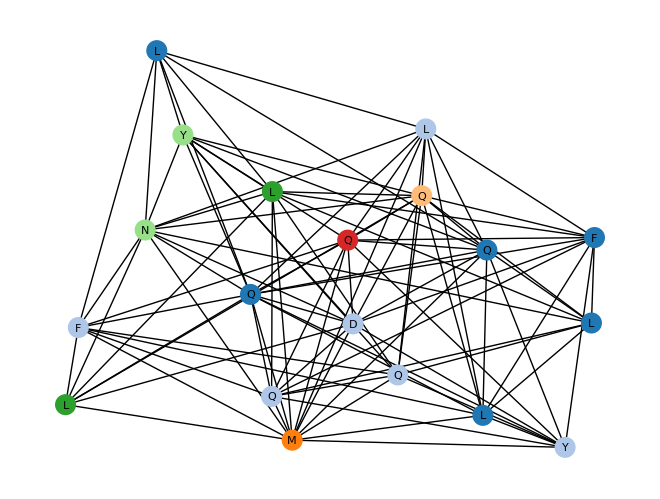

Number of nodes: 15
Number of edges: 136
Node features shape: torch.Size([15, 27])


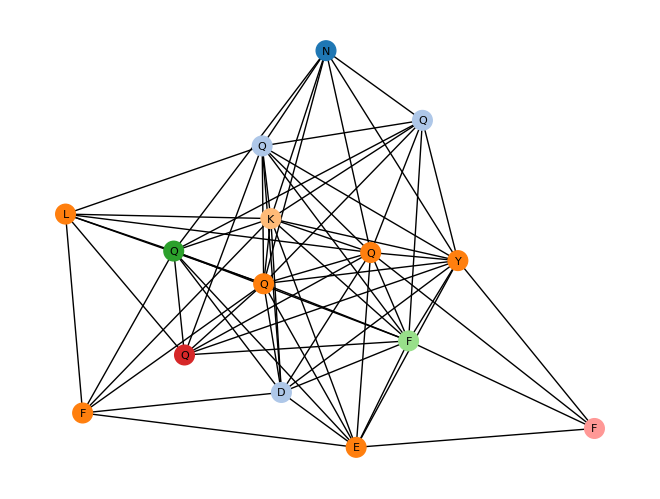

Number of nodes: 14
Number of edges: 110
Node features shape: torch.Size([14, 27])


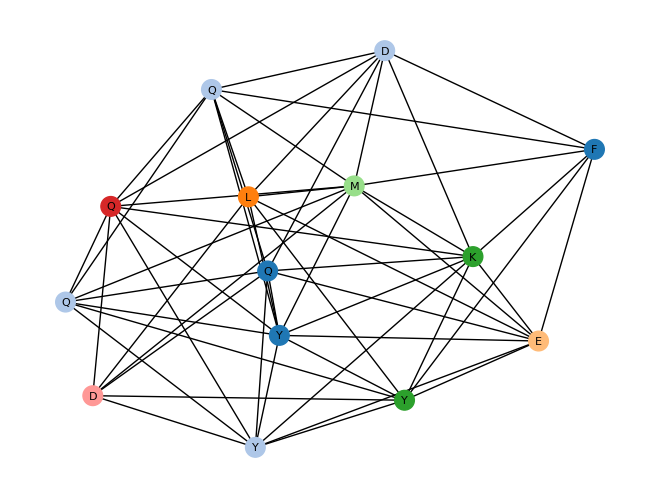

Number of nodes: 19
Number of edges: 210
Node features shape: torch.Size([19, 27])


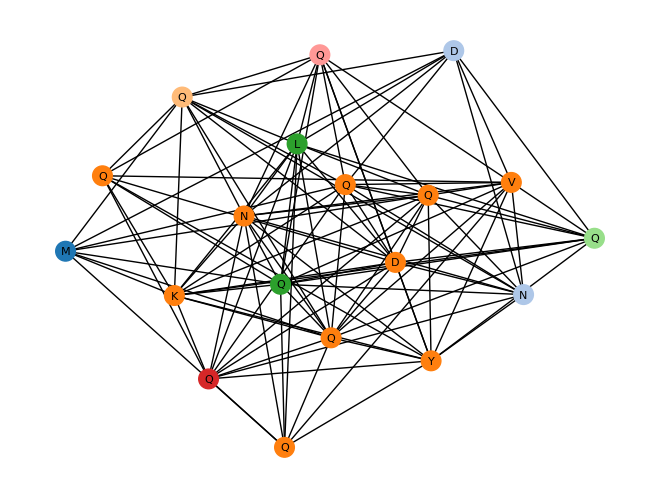

Number of nodes: 19
Number of edges: 192
Node features shape: torch.Size([19, 27])


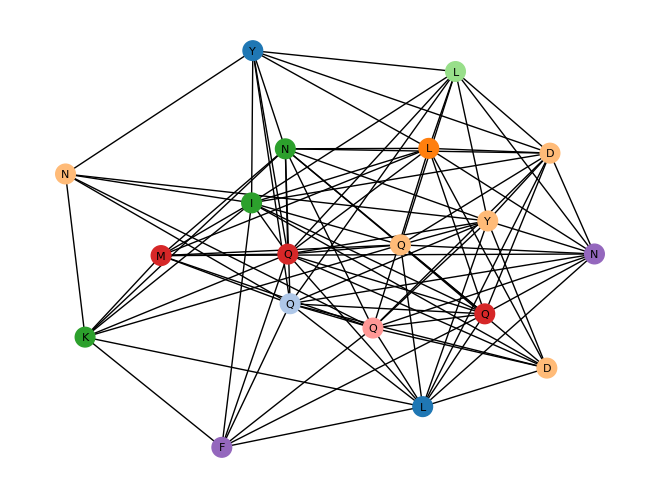

Number of nodes: 12
Number of edges: 66
Node features shape: torch.Size([12, 27])


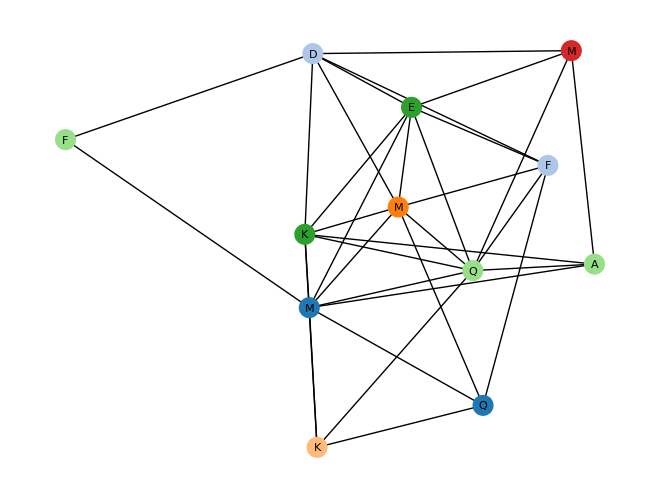

Number of nodes: 12
Number of edges: 70
Node features shape: torch.Size([12, 27])


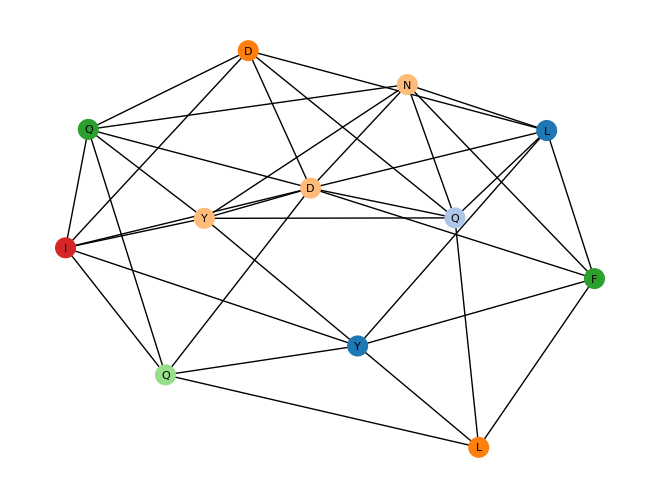

In [16]:
for i, graph in enumerate(gen_molecules):
    graph_creator.print_graph_metrics(graph)
    graph_creator.draw_graph(graph, onehot_encoder)

In [17]:
# Create example dataset
class MoleculeDataset(tg_data.Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data = data_list

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]

In [18]:
from sklearn.model_selection import train_test_split

# Assuming `graphs` is your list of graphs
train_data, val_data = train_test_split(graphs, test_size=0.2, random_state=42)

print(f"Number of training graphs: {len(train_data)}")
print(f"Number of validation graphs: {len(val_data)}")

Number of training graphs: 4000
Number of validation graphs: 1000


In [ ]:
train_dataset = MoleculeDataset(train_data)
val_dataset = MoleculeDataset(val_data)

# Setup training
training_params = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 10,
    'num_workers': 0,
    'gradient_clip_val': 1.0,
    'beta': 0.1
}
prefetch_factor = None if training_params['num_workers'] == 0 else 2

# Train using the pipeline
model, trainer = train_gvae(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_params=model_params,
    training_params=training_params,
    )



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/alexchilton/DataspellProjects/laras_code/untitled/checkpoints exists and is not empty.
Restoring states from the checkpoint path at checkpoints/gvae-epoch=01-train_loss=22.47.ckpt

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | MolecularGVAE | 27.3 K | train
------------------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/gvae-epoch=01-train_loss=22.47.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [20]:
# Assuming `lightning_model` is an instance of `MolecularGVAEModule`
num_nodes = 50  # Specify the number of nodes you want to generate
generated_graph = base_model.generate(num_nodes=num_nodes, device='cpu')

# Print the generated graph
print(generated_graph)

Data(x=[50, 27], edge_index=[2, 1528])


In [21]:
gen_molecules = generate_diverse_molecules(base_model, size_range=(10, 20), num_molecules=10)

graph_creator.print_first_graph(gen_molecules)


Node 1: tensor([0.2792, 0.1941, 0.4154, 0.6613, 0.3345, 0.6513, 0.5116, 0.6191, 0.2408,
        0.5374, 0.6781, 0.6896, 0.5476, 0.4585, 0.6561, 0.5458, 0.4047, 0.6612,
        0.5464, 0.3522, 0.5731, 0.4174, 0.3378, 0.4708, 0.6234, 0.6053, 0.6747])
Node 2: tensor([0.5464, 0.5379, 0.2600, 0.2938, 0.3959, 0.7036, 0.3644, 0.6467, 0.4276,
        0.6383, 0.4162, 0.3454, 0.5788, 0.5425, 0.3897, 0.4613, 0.6793, 0.4429,
        0.6055, 0.4299, 0.2936, 0.5150, 0.4154, 0.4331, 0.5123, 0.4928, 0.5830])
Node 3: tensor([0.5732, 0.4294, 0.5859, 0.5379, 0.6313, 0.6594, 0.7030, 0.3544, 0.2500,
        0.3144, 0.5242, 0.3597, 0.5584, 0.3465, 0.4729, 0.5027, 0.3302, 0.6000,
        0.4522, 0.3159, 0.8092, 0.3297, 0.6385, 0.4935, 0.5115, 0.6518, 0.5615])
Node 4: tensor([0.3436, 0.1929, 0.3974, 0.6629, 0.3253, 0.6673, 0.4751, 0.6028, 0.2694,
        0.6065, 0.6495, 0.6946, 0.5187, 0.4413, 0.6785, 0.5220, 0.4069, 0.6284,
        0.5618, 0.3367, 0.5477, 0.4093, 0.3282, 0.5139, 0.6484, 0.6197, 0.7279])
Node

In [22]:
# Convert the `AA_` columns in the generated protein graphs to one-hot encoded format
gen_molecules = graph_creator.convert_graphs_to_one_hot(gen_molecules)

In [23]:
# Print each node's features for the first graph
graph_creator.print_first_graph(gen_molecules)

Node 1: tensor([0.2792, 0.1941, 0.4154, 0.6613, 0.3345, 0.6513, 0.5116, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node 2: tensor([0.5464, 0.5379, 0.2600, 0.2938, 0.3959, 0.7036, 0.3644, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node 3: tensor([0.5732, 0.4294, 0.5859, 0.5379, 0.6313, 0.6594, 0.7030, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Node 4: tensor([0.3436, 0.1929, 0.3974, 0.6629, 0.3253, 0.6673, 0.4751, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000])
Node

Number of nodes: 10
Number of edges: 54
Node features shape: torch.Size([10, 27])


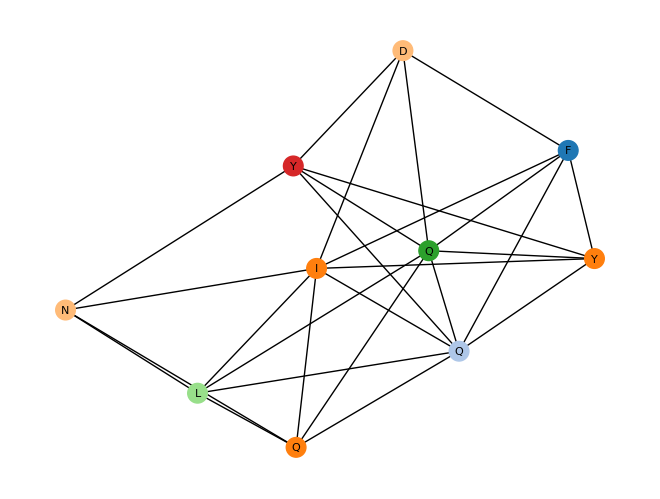

Number of nodes: 16
Number of edges: 130
Node features shape: torch.Size([16, 27])


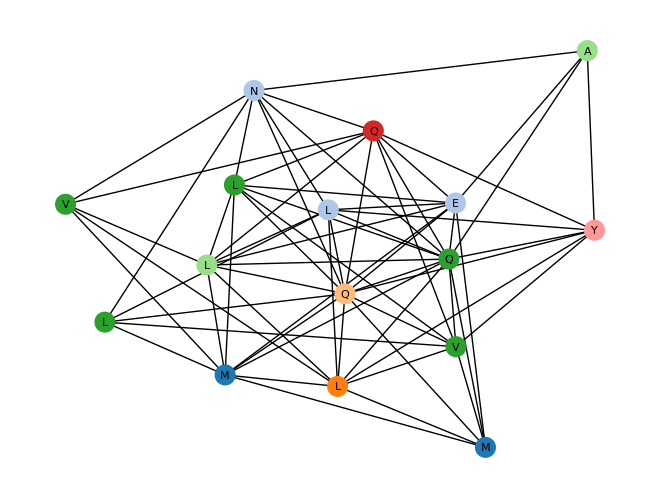

Number of nodes: 17
Number of edges: 170
Node features shape: torch.Size([17, 27])


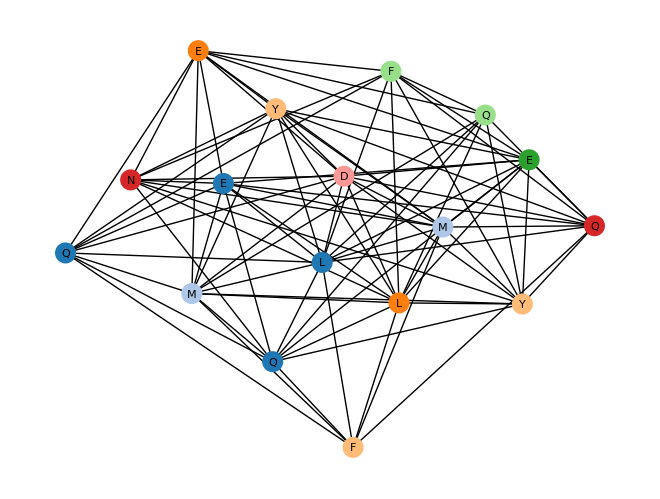

Number of nodes: 19
Number of edges: 200
Node features shape: torch.Size([19, 27])


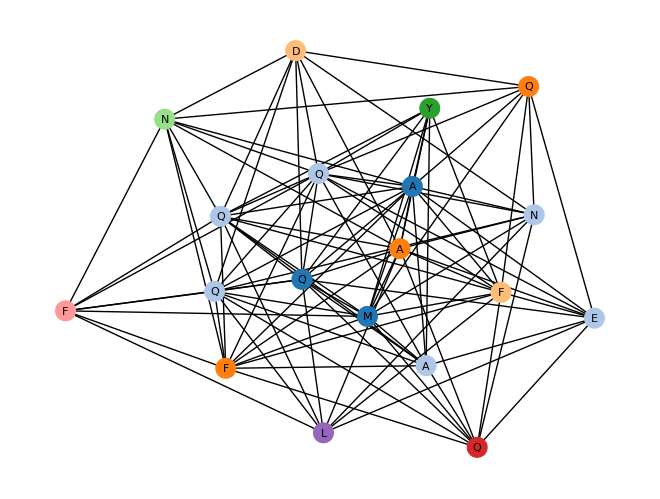

Number of nodes: 13
Number of edges: 112
Node features shape: torch.Size([13, 27])


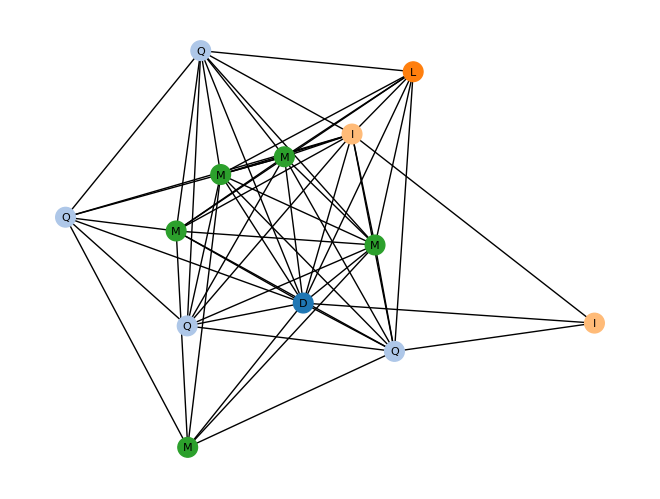

Number of nodes: 14
Number of edges: 90
Node features shape: torch.Size([14, 27])


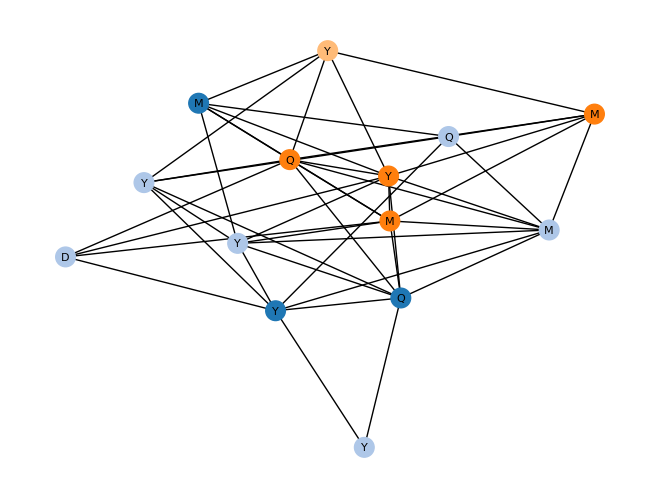

Number of nodes: 17
Number of edges: 174
Node features shape: torch.Size([17, 27])


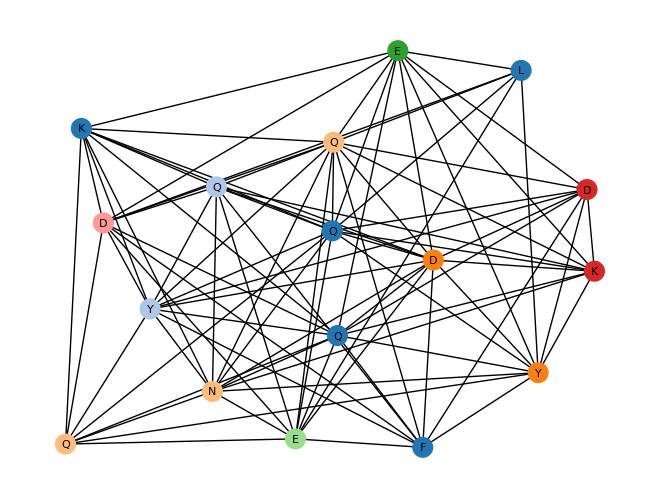

Number of nodes: 18
Number of edges: 196
Node features shape: torch.Size([18, 27])


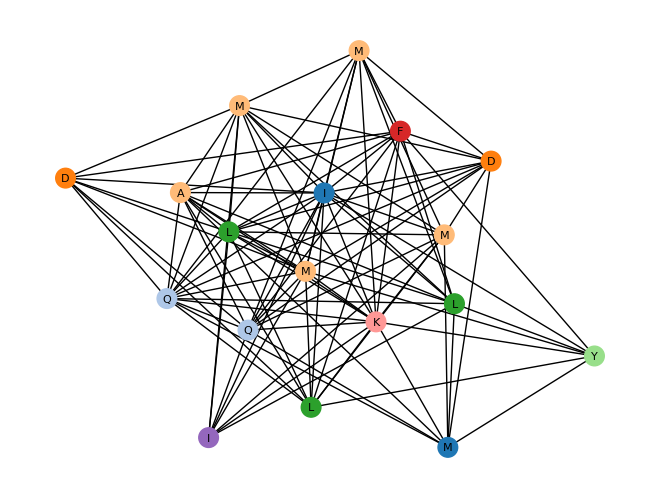

Number of nodes: 16
Number of edges: 140
Node features shape: torch.Size([16, 27])


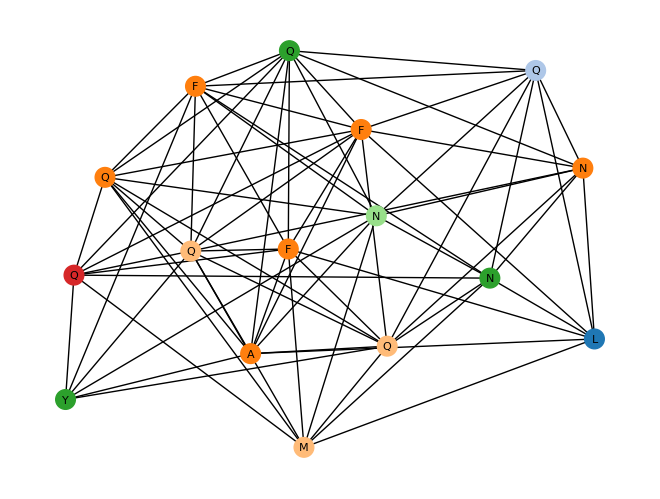

Number of nodes: 10
Number of edges: 58
Node features shape: torch.Size([10, 27])


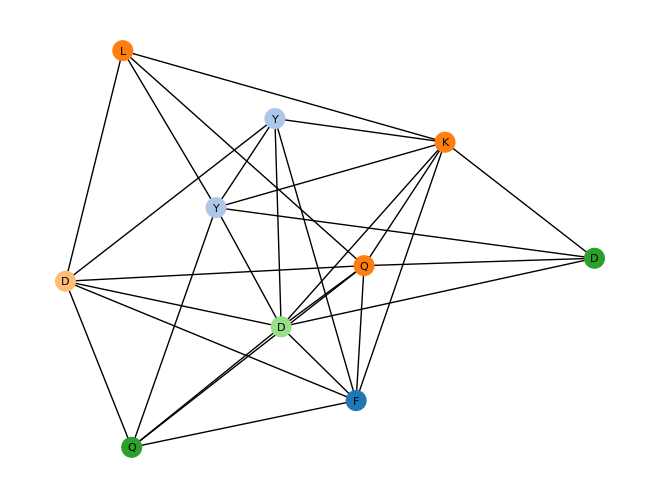

In [24]:
for i, graph in enumerate(gen_molecules):
    graph_creator.print_graph_metrics(graph)
    graph_creator.draw_graph(graph, onehot_encoder)

### Pad Graphs to Have the Same Number of Nodes

### Print the First Padded Graph and see that the padding has been done

### Define the Graph Variational Autoencoder Model

### Prepare the Graph Variational Autoencoder Model

### Train the Graph Variational Autoencoder Model

### Generate New Graphs

### Convert the `AA_` columns in the generated protein graphs to one-hot encoded format

### Prune Small Subgraphs

### Print the Generated Protein Graphs